In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from utils.bar_makers import get_bars
from utils.threshold_calculators import calculate_tick_threshold_constant, calculate_dollar_threshold_constant, calculate_volume_threshold_constant
from utils.threshold_calculators import create_metric_threshold_series
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlepad'] = 20

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

np.random.seed(142)


### Reading the nanosecond tick data

In [2]:
data_path = Path("ticks_data_ns")
tick_data_path = data_path / "googl_trade_2023_05_12.txt"
saving_dir = 'bars'

ticks_df = pd.read_csv(tick_data_path.resolve(), sep=",", header=None, names=["date_time", "price", "volume", "exchange_code", "trading_condition"])
ticks_df['date_time'] = pd.to_datetime(ticks_df['date_time'], unit='ns')
ticks_df = ticks_df.drop(columns=["exchange_code", "trading_condition"])
display(ticks_df.tail(10))

,date_time,price,volume
315630,2023-05-12 19:58:16.120889,117.80,1
315631,2023-05-12 19:59:41.363285,117.80,22
315632,2023-05-12 19:59:46.414233,117.80,22
315633,2023-05-12 19:59:46.418670,117.80,1
315634,2023-05-12 19:59:46.429107,117.79,1
315635,2023-05-12 19:59:50.926143,117.80,22
315636,2023-05-12 19:59:50.926145,117.79,191
315637,2023-05-12 19:59:54.694862,117.79,3
315638,2023-05-12 19:59:57.658127,117.79,10
315639,2023-05-12 19:59:59.770677,117.80,10


### Creating time bars

In [3]:
# allowed resolutions: 'D': day, 'H': hour, 'M': minute, 'S': second
# num_units: number of units of resolution to aggregate
time_bars = get_bars(ticks_df, resolution='M', num_units=30, batch_size=1e6, verbose=True, bar_type='time')
time_bars.head(3)

Reading data in batches:
Batch number: 0
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2023-05-12 04:00:00,323,116.90,117.80,116.90,117.55,14339.0,8150.0,322,1684818.52
1,2023-05-12 04:30:00,428,117.56,117.65,117.44,117.65,4399.0,1266.0,105,517038.10
2,2023-05-12 05:00:00,516,117.61,117.65,117.47,117.47,4679.0,346.0,88,549965.07


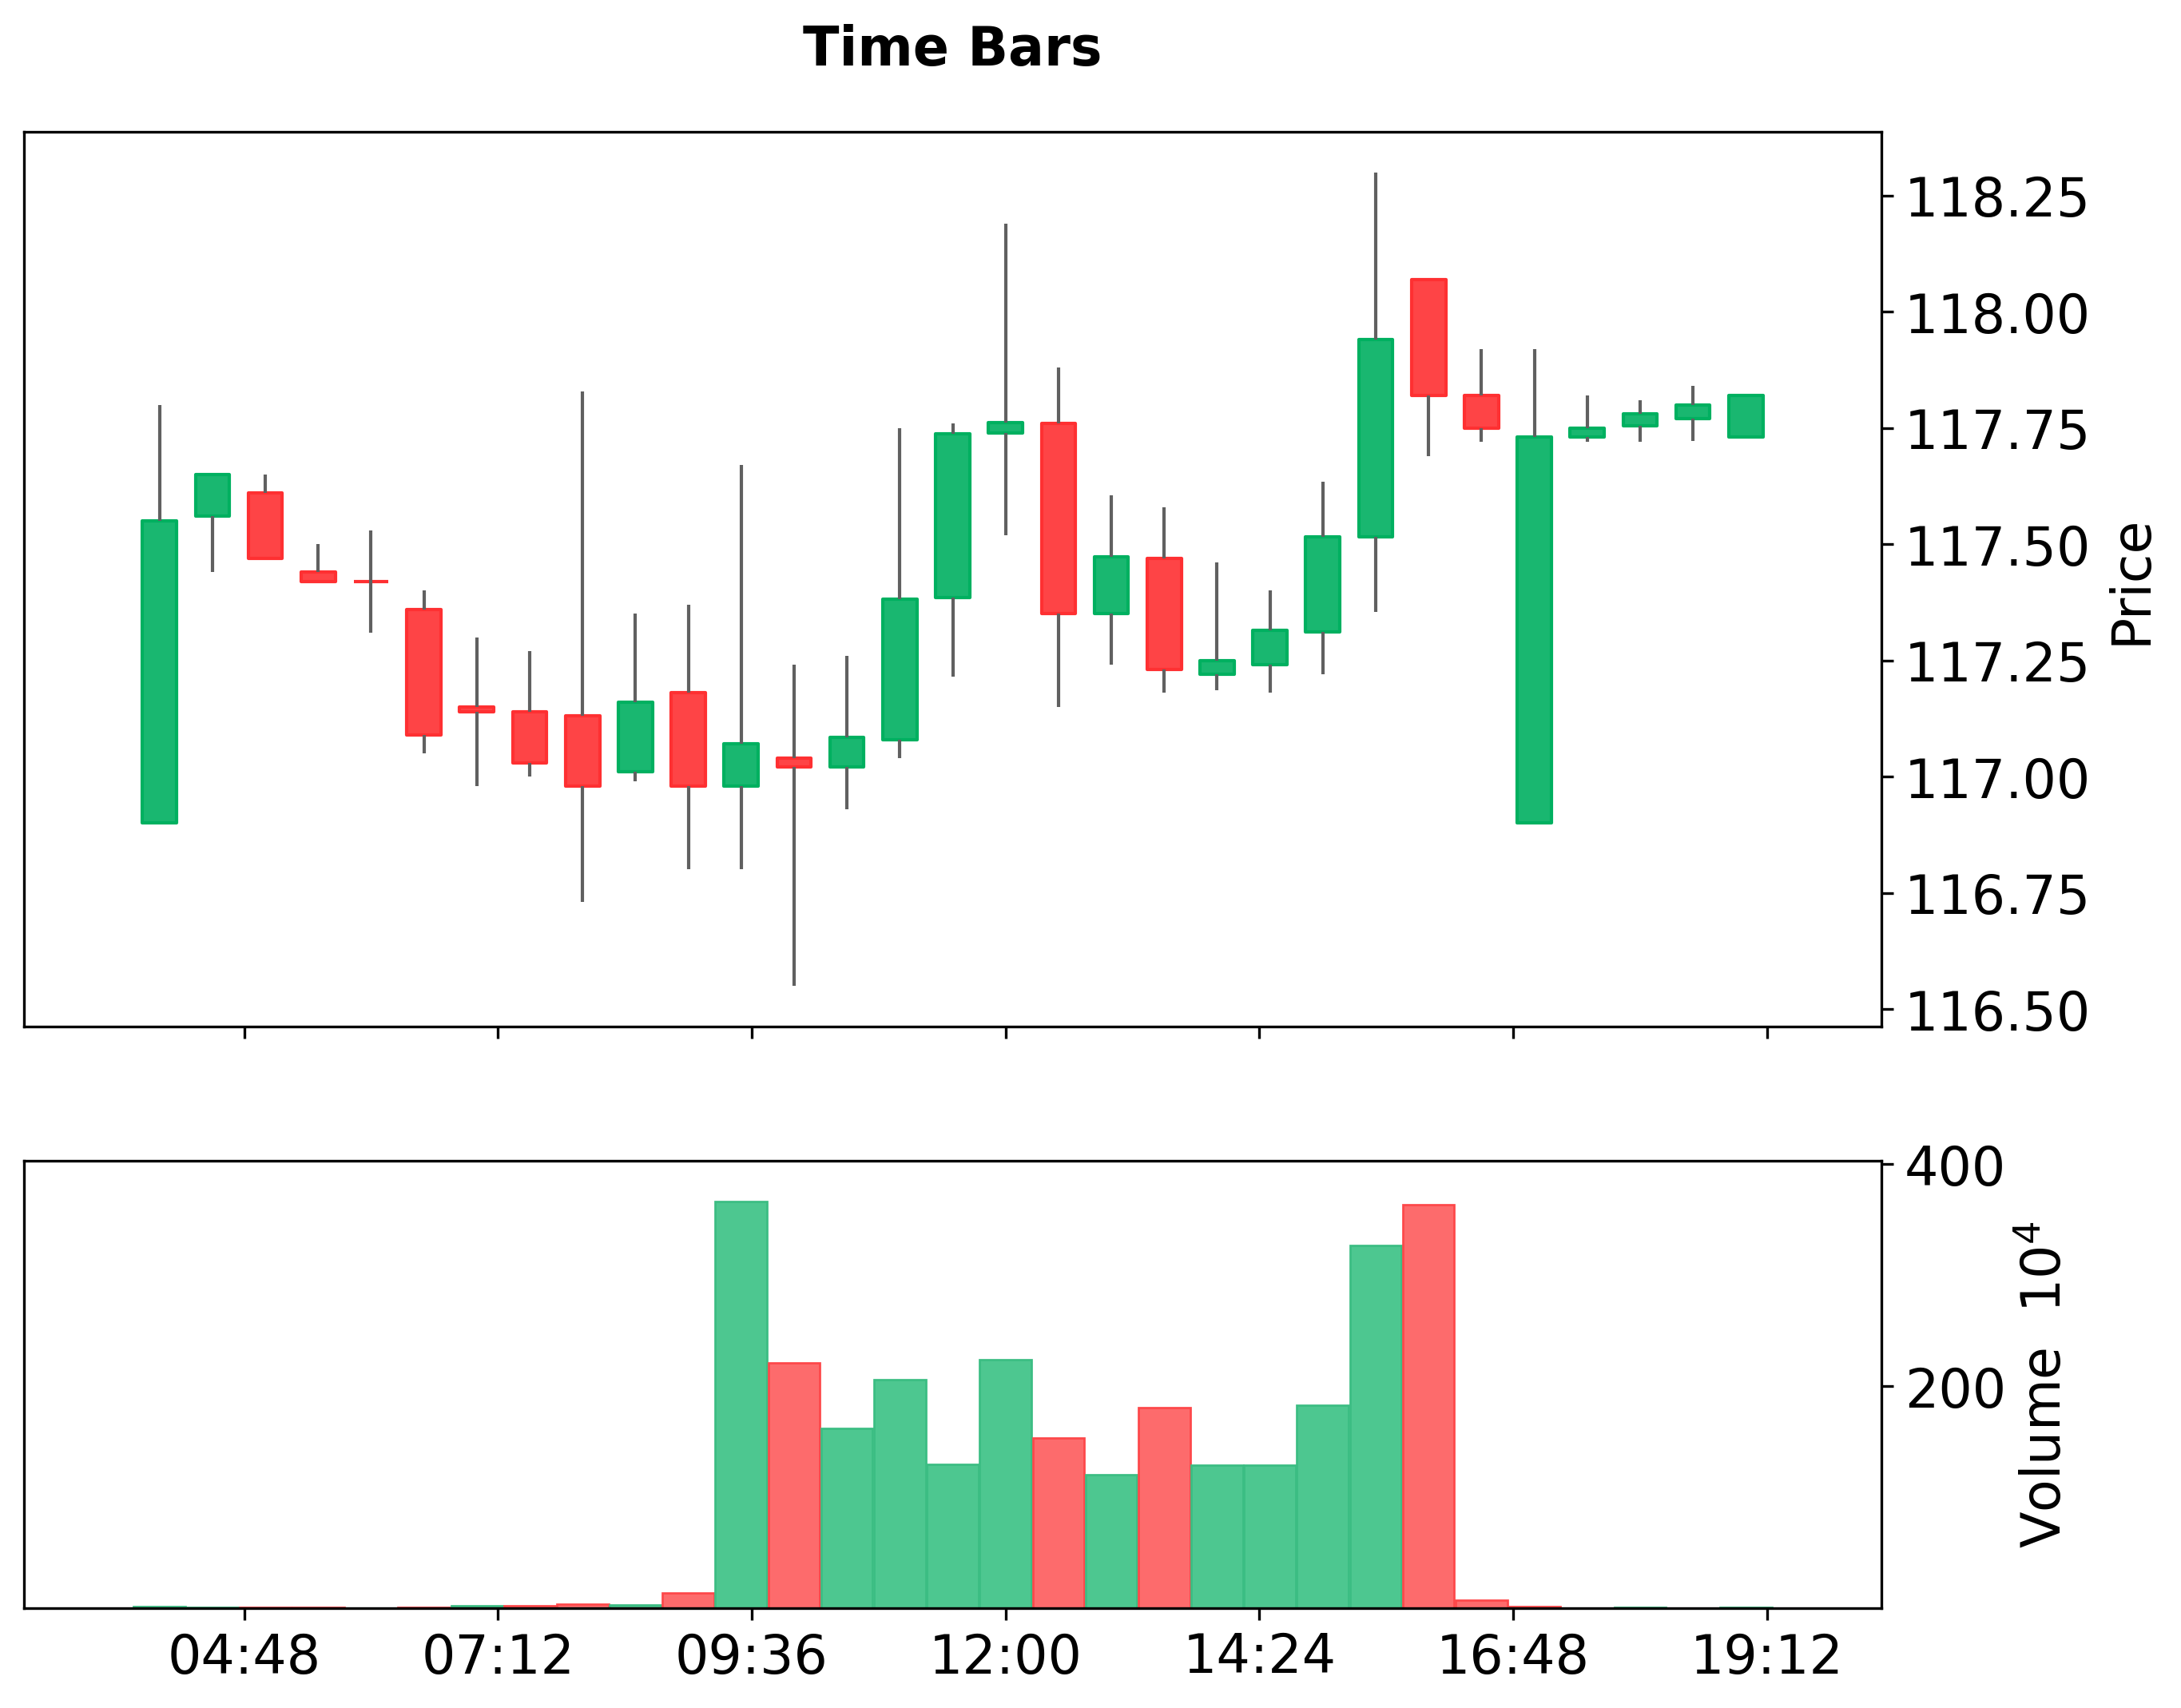

In [4]:
bars = time_bars.copy().set_index('date_time')
fig, axs = plt.subplots(2, 1, figsize=(10, 8),
                        dpi=300, sharex=True,
                        height_ratios=[2,1])
axs[1].yaxis.set_ticks_position('right')
axs[1].yaxis.set_label_position('right')
axs[0].set_title('Time Bars')

mpf.plot(bars, type='candle', style='yahoo',
        ax=axs[0], show_nontrading=True, volume_exponent=4,
        volume=axs[1], xrotation=0, tight_layout=False)
del bars

### Creating Volume bars

In [5]:
volume_threshold = calculate_volume_threshold_constant(ticks_df, lookback=1e6, num_bars_per_day=50)
volume_bars = get_bars(ticks_df, threshold=volume_threshold, batch_size=1e6, verbose=True, bar_type='volume')
volume_bars.head(3)

volume threshold: 586258.7
Reading data in batches:
Batch number: 0
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2023-05-12 09:30:01,6327,116.90,117.8285,116.73,116.97,748864.0,124598.0,6326,8.764496e+07
1,2023-05-12 09:33:00,14620,116.98,117.6400,116.80,117.37,586286.0,307779.0,8293,6.873097e+07
2,2023-05-12 09:37:56,23396,117.38,117.6700,117.00,117.25,586294.0,275648.0,8776,6.882380e+07


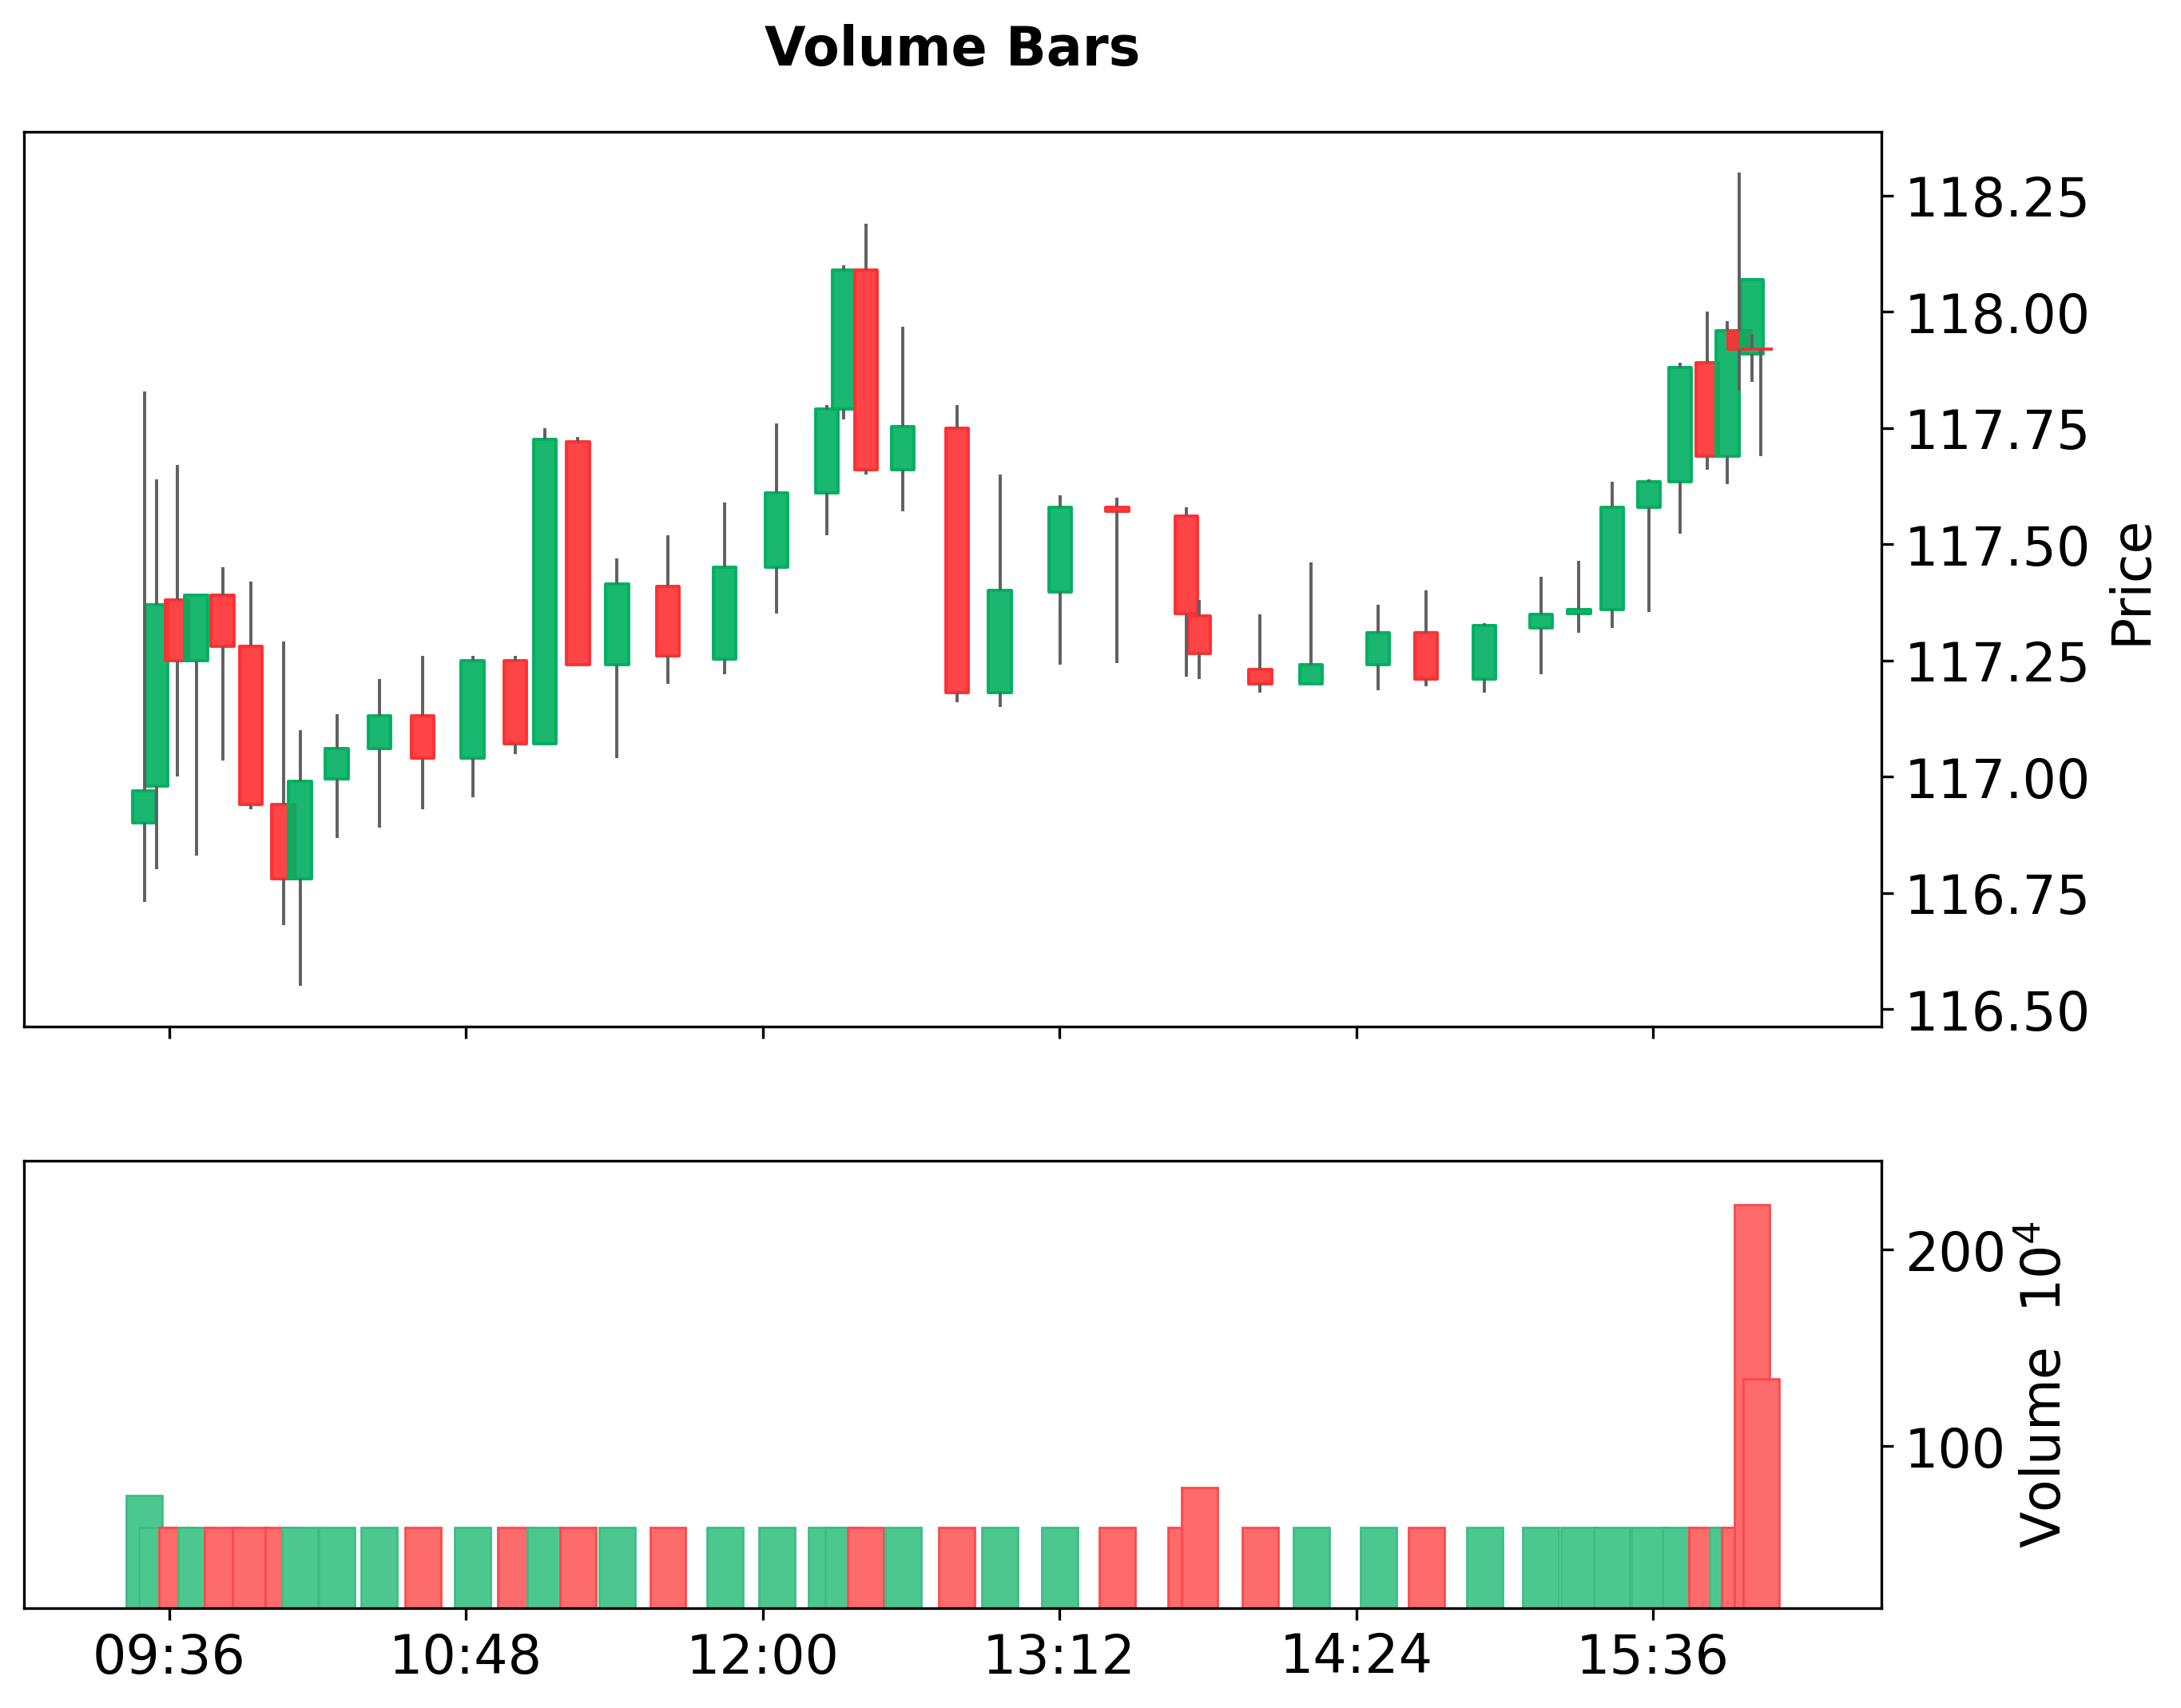

In [6]:
bars = volume_bars.copy().set_index('date_time')
fig, axs = plt.subplots(2, 1, figsize=(10, 8),
                        dpi=300, sharex=True,
                        height_ratios=[2,1])
axs[1].yaxis.set_ticks_position('right')
axs[1].yaxis.set_label_position('right')
axs[0].set_title('Volume Bars')
mpf.plot(bars, type='candle', style='yahoo',
        ax=axs[0], show_nontrading=True, volume_exponent=4,
        volume=axs[1], xrotation=0, tight_layout=False)
del bars

### Creating Dollar bars

In [7]:
dollar_threshold = calculate_dollar_threshold_constant(ticks_df, lookback=1e6, num_bars_per_day=50)
dollar_bars = get_bars(ticks_df, threshold=dollar_threshold, batch_size=1e6, verbose=True, bar_type='dollar')
# dollar_bars.to_hdf(Path(f"{saving_dir}/dollar_bars.h5").resolve(), key='dollar_bars', mode='w')
print(f'Dollar bars shape: {dollar_bars.shape}')
dollar_bars.head(3)

Dollar Threshold: 68866200.75
Reading data in batches:
Batch number: 0
Returning bars 

Dollar bars shape: (44, 10)


,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2023-05-12 09:30:01,6327,116.90,117.8285,116.73,116.9700,748864.0,124598.0,6326,8.764496e+07
1,2023-05-12 09:33:01,14645,116.98,117.6400,116.80,117.4100,587441.0,308437.0,8318,6.886657e+07
2,2023-05-12 09:37:57,23436,117.41,117.6700,117.00,117.2196,586836.0,275637.0,8791,6.888716e+07


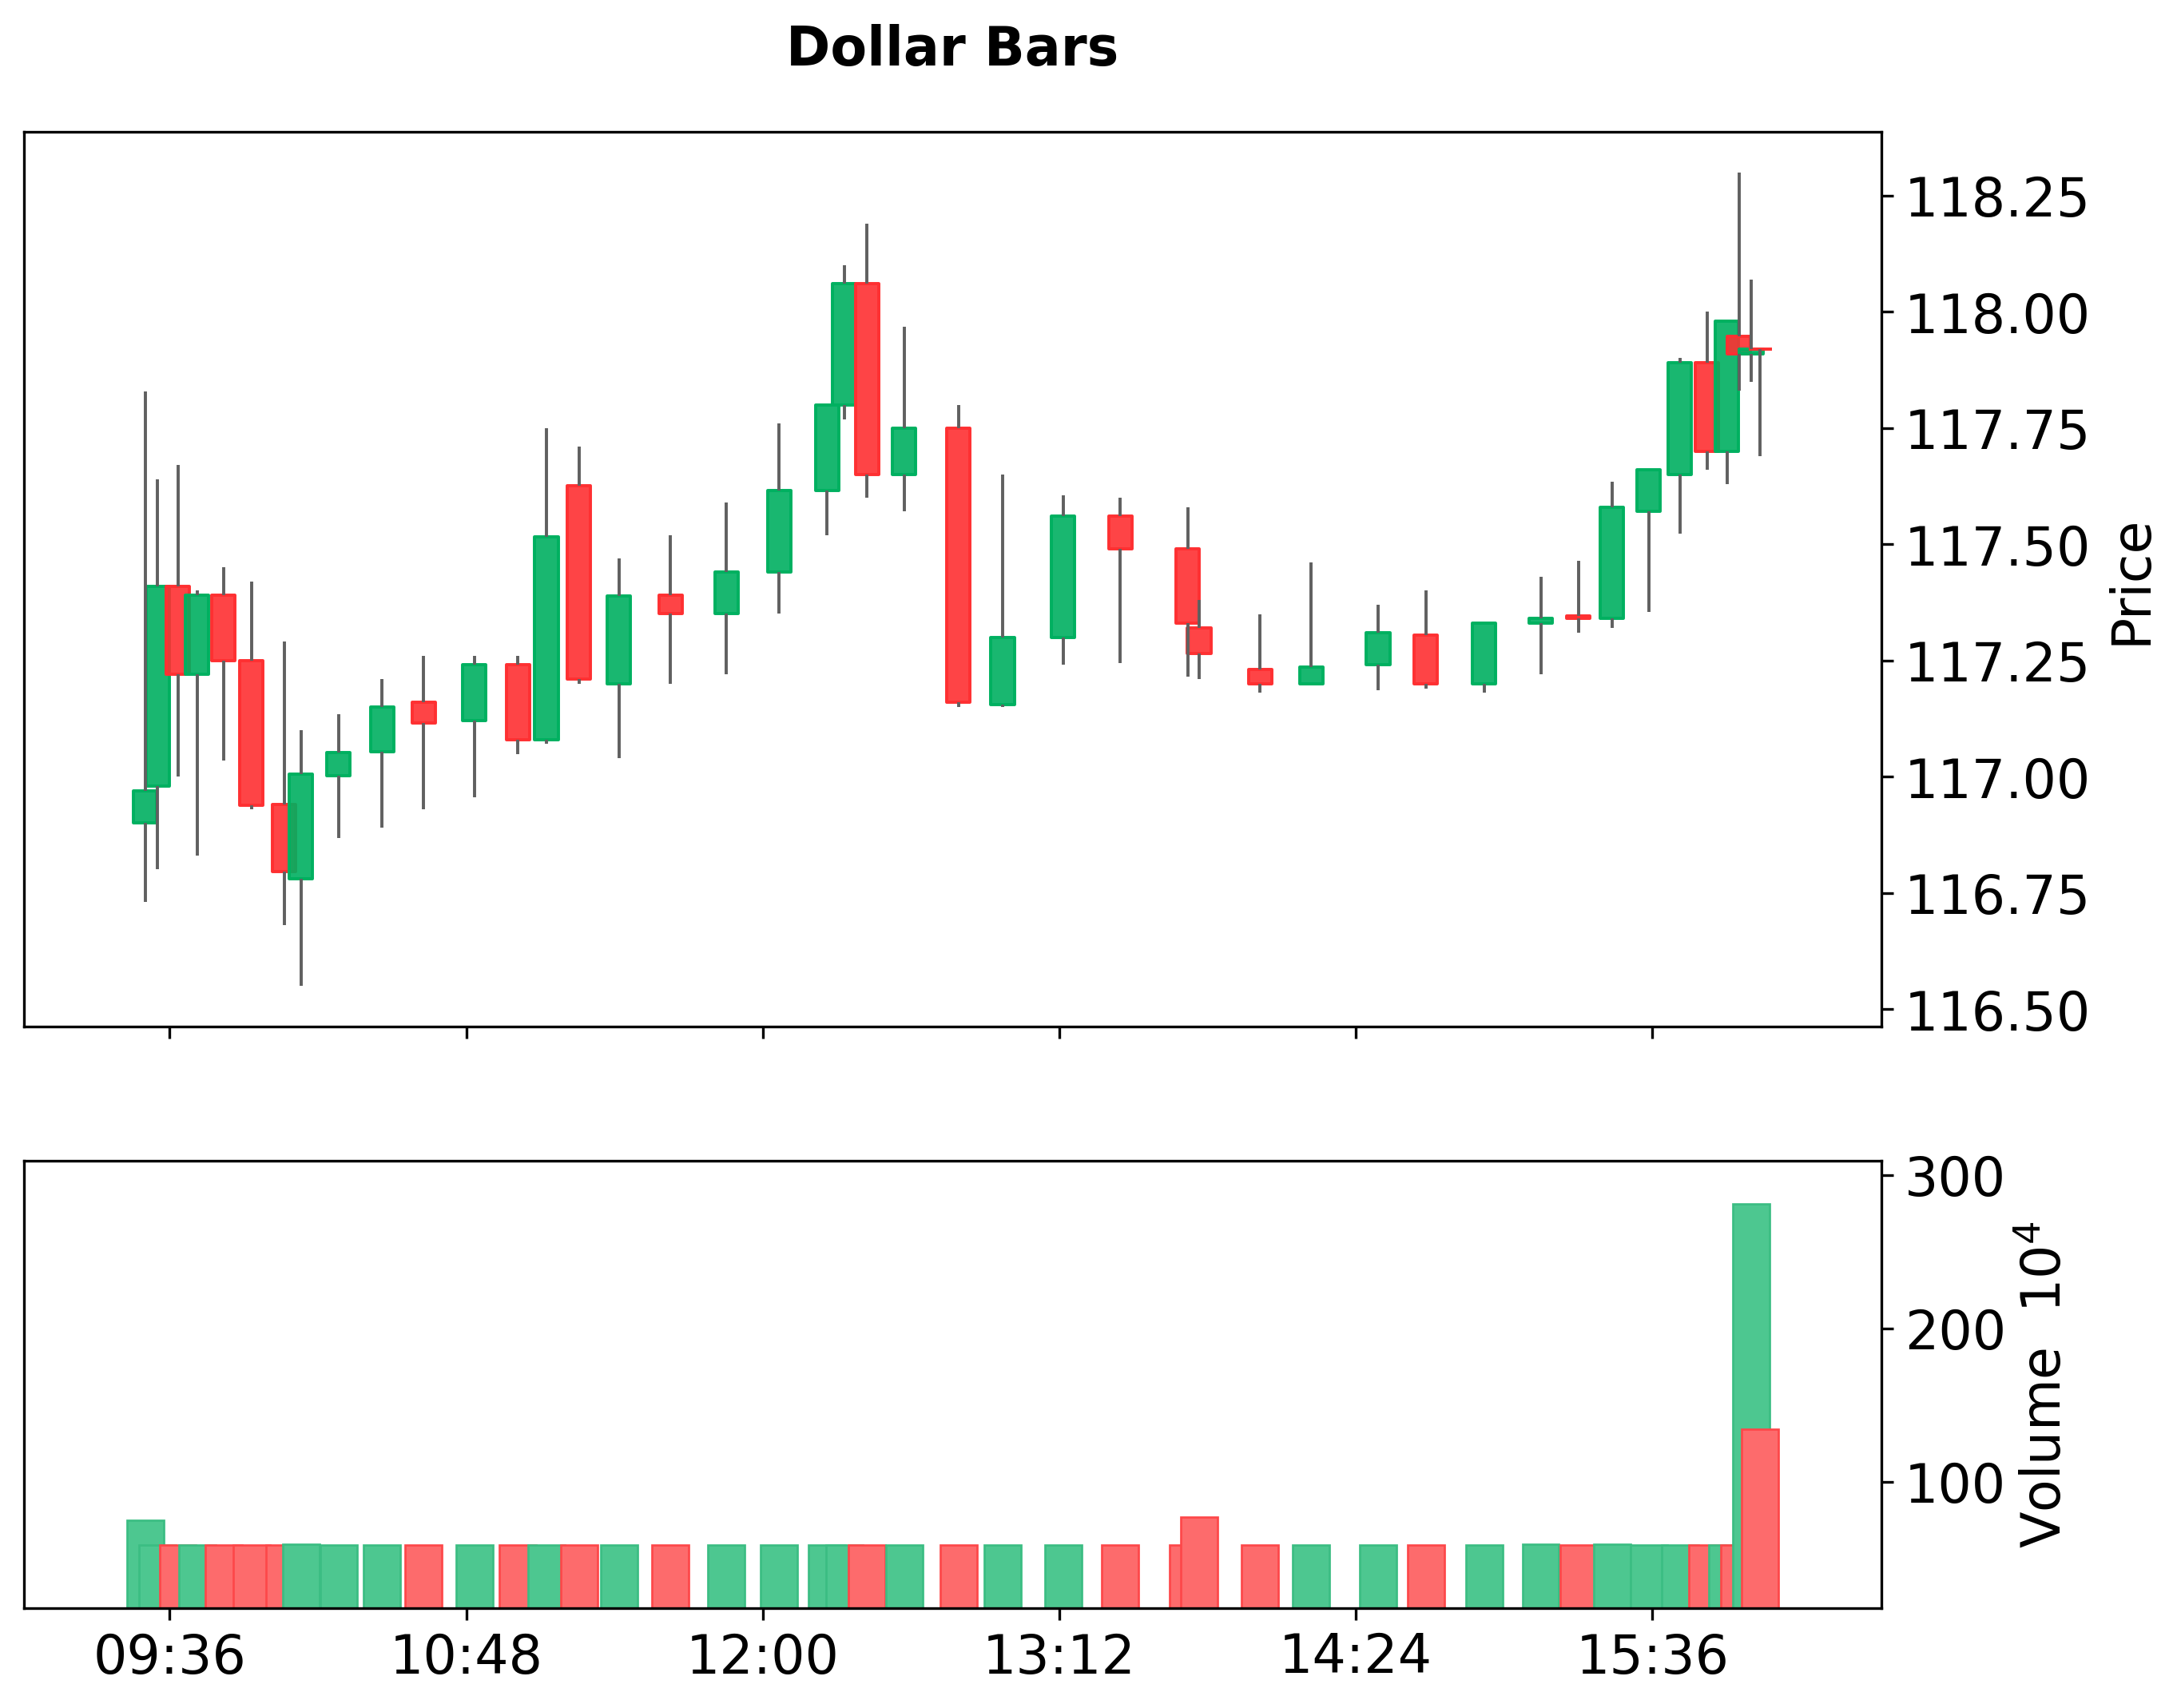

In [8]:
bars = dollar_bars.copy().set_index('date_time')
fig, axs = plt.subplots(2, 1, figsize=(10, 8),
                        dpi=300, sharex=True,
                        height_ratios=[2,1])
axs[1].yaxis.set_ticks_position('right')
axs[1].yaxis.set_label_position('right')
axs[0].set_title('Dollar Bars')
mpf.plot(bars, type='candle', style='yahoo',
        ax=axs[0], show_nontrading=True, volume_exponent=4,
        volume=axs[1], xrotation=0, tight_layout=False)
del bars

### Creating tick bars

In [9]:
tick_threshold = calculate_tick_threshold_constant(ticks_df, lookback=1e6, num_bars_per_day=50)
tick_bars = get_bars(ticks_df, threshold=tick_threshold, batch_size=1e6, verbose=True, bar_type='tick')
# dollar_bars.to_hdf(Path(f"{saving_dir}/tick_bars.h5").resolve(), key='tick_bars', mode='w')
print(f'Tick bars shape: {tick_bars.shape}')
tick_bars.date_time = pd.to_datetime(tick_bars.date_time)
tick_bars.head(3)	

tick threshold: 6312.8
Reading data in batches:
Batch number: 0
Returning bars 

Tick bars shape: (49, 10)


,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2023-05-12 09:30:01,6314,116.90,117.8285,116.730,117.005,331035.0,124388.0,6313,3.877149e+07
1,2023-05-12 09:32:11,12627,116.99,117.3900,116.800,117.350,829687.0,211684.0,6313,9.710785e+07
2,2023-05-12 09:35:23,18940,117.35,117.6700,117.064,117.160,477878.0,238521.0,6313,5.614259e+07


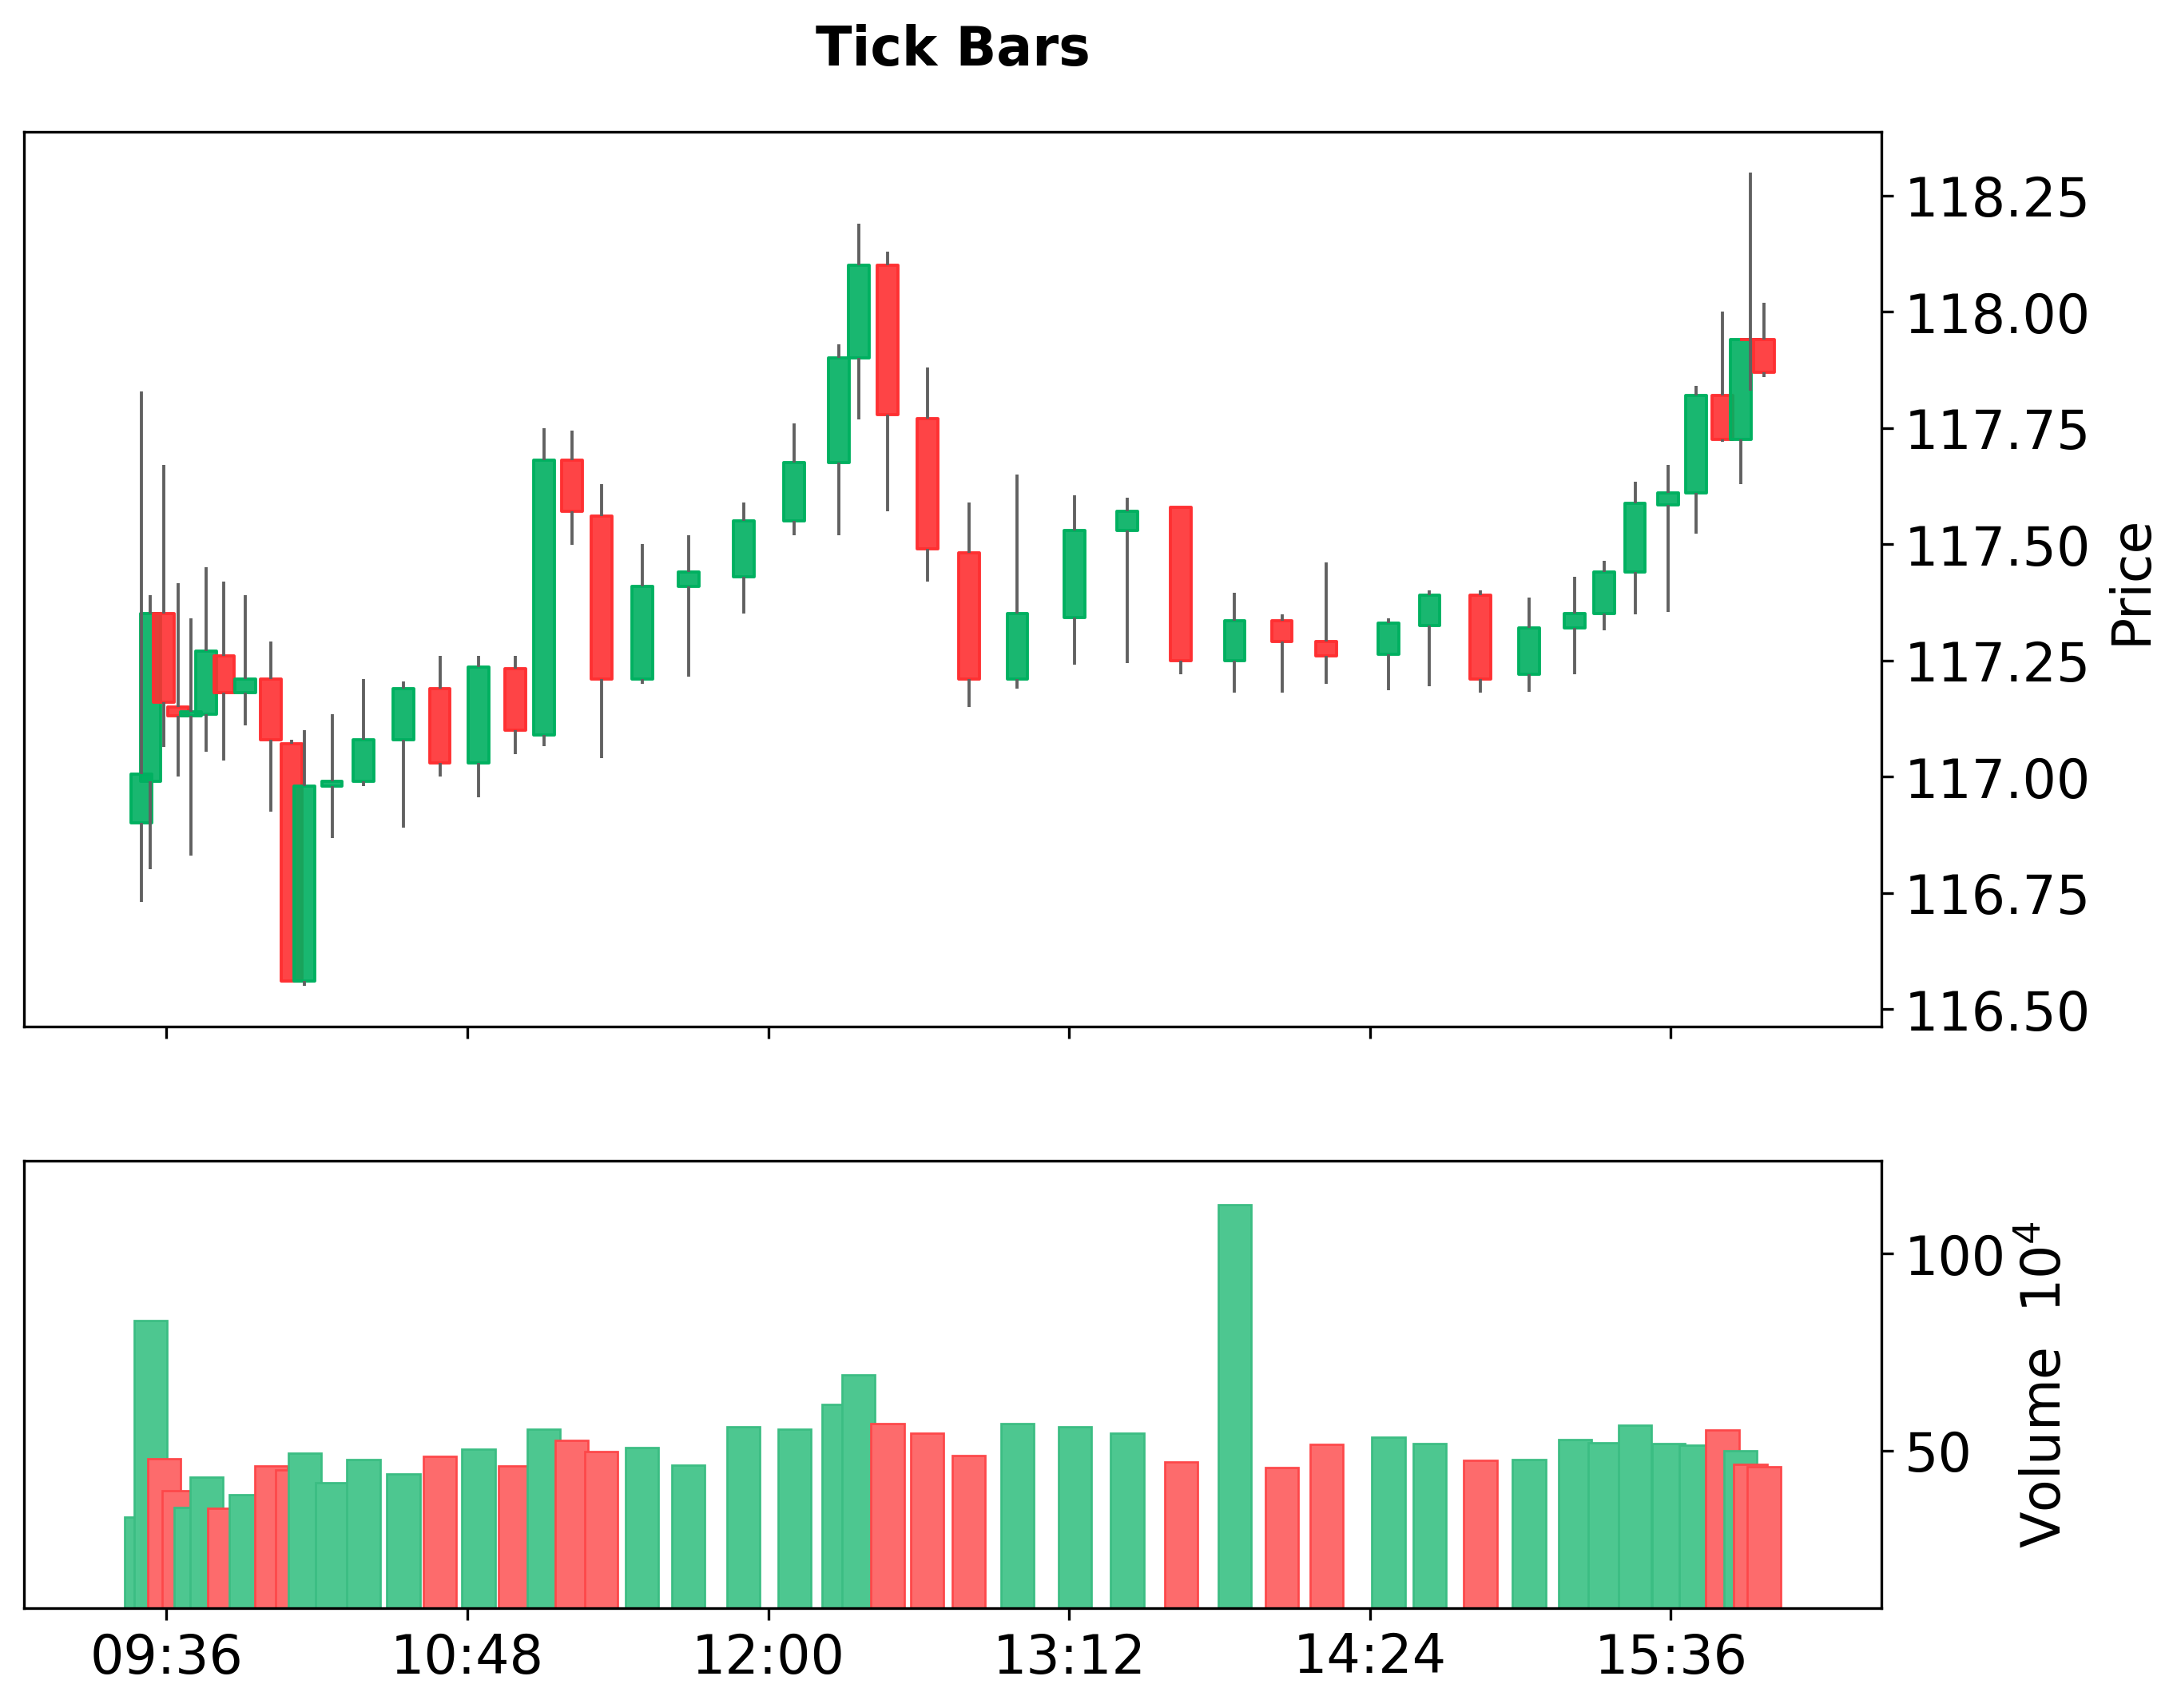

In [10]:
bars = tick_bars.copy().set_index('date_time')
fig, axs = plt.subplots(2, 1, figsize=(10, 8),
                        dpi=300, sharex=True,
                        height_ratios=[2,1])
axs[1].yaxis.set_ticks_position('right')
axs[1].yaxis.set_label_position('right')
axs[0].set_title('Tick Bars')
mpf.plot(bars, type='candle', style='yahoo',
        ax=axs[0], show_nontrading=True, volume_exponent=4,
        volume=axs[1], xrotation=0, tight_layout=False)
del bars

In [11]:
# threshold_series = create_metric_threshold_series(ticks_df, metric='volume', window=2, resolution='ME')
# variables_thresh_dollar_bars = get_bars(ticks_df, threshold=threshold_series, batch_size=1e6, verbose=True, bar_type='volume')
# variables_thresh_dollar_bars.head(3)

In [12]:
time_returns = np.log(1 + time_bars['close'].pct_change()).dropna()
time_returns[np.isinf(time_returns)] = 0
result = stats.jarque_bera(time_returns)	
print(f'Time Bars Jarque-Bera Test:\nstatistics: {round(result.statistic, 2)}, p_value: {round(result.pvalue, 2)}')
print(f'length: {len(time_bars)} bars\n')


tick_returns = np.log(1 + tick_bars['close'].pct_change()).dropna()
tick_returns[np.isinf(tick_returns)] = 0
result = stats.jarque_bera(tick_returns)
print(f'Tick Bars Jarque-Bera Test:\nstatistics: {round(result.statistic, 2)}, p_value: {round(result.pvalue, 2)}')
print(f'length: {len(tick_bars)} bars\n')


dollar_returns = np.log(1 + dollar_bars['close'].pct_change()).dropna()
dollar_returns[np.isinf(dollar_returns)] = 0
result = stats.jarque_bera(dollar_returns)
print(f'Dollar Bars Jarque-Bera Test:\nstatistics: {round(result.statistic, 2)}, p_value: {round(result.pvalue, 2)}')
print(f'length: {len(dollar_bars)} bars\n')

volume_returns = np.log(1 + volume_bars['close'].pct_change()).dropna()
volume_returns[np.isinf(volume_returns)] = 0
resukt = stats.jarque_bera(volume_returns)
print(f'Volume Bars Jarque-Bera Test:\nstatistics: {round(result.statistic, 2)}, p_value: {round(result.pvalue, 2)}')
print(f'length: {len(volume_bars)} bars\n')


Time Bars Jarque-Bera Test:
statistics: 0.28, p_value: 0.87
length: 31 bars

Tick Bars Jarque-Bera Test:
statistics: 0.92, p_value: 0.63
length: 49 bars

Dollar Bars Jarque-Bera Test:
statistics: 2.39, p_value: 0.3
length: 44 bars

Volume Bars Jarque-Bera Test:
statistics: 2.39, p_value: 0.3
length: 45 bars



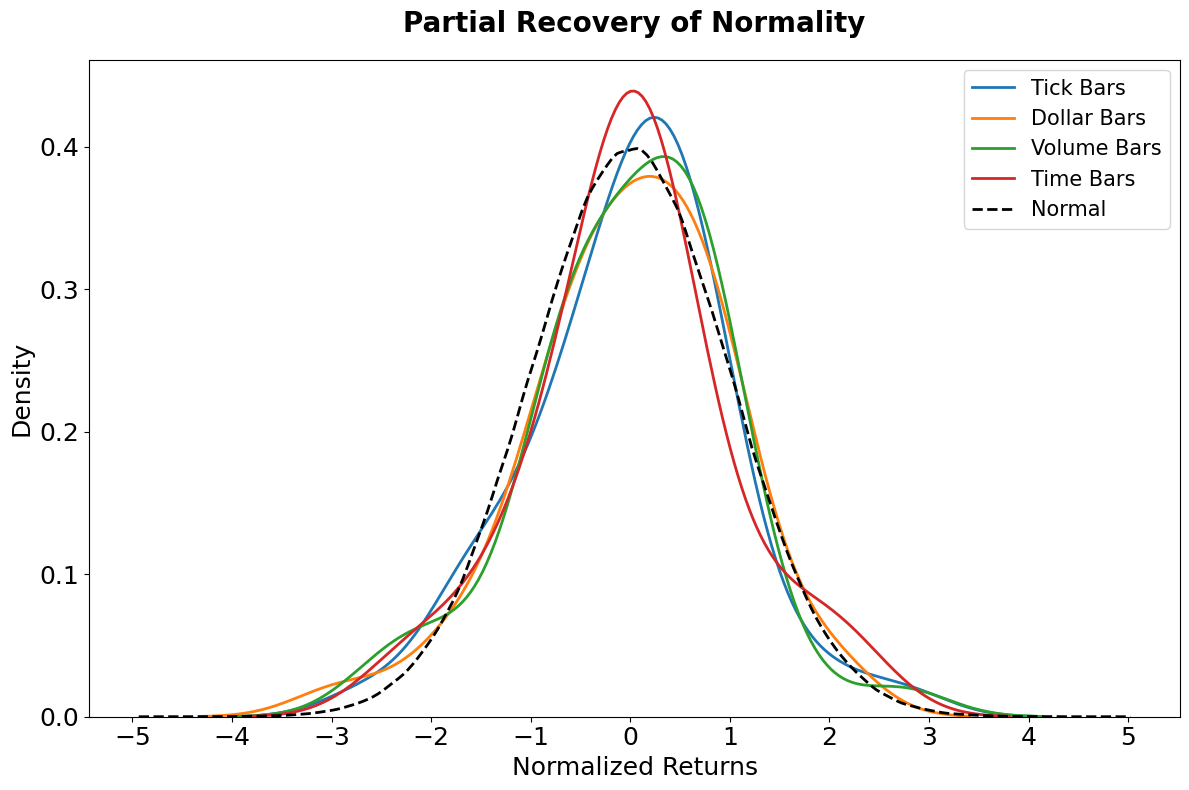

In [13]:
normalized_tick_returns = (tick_returns - tick_returns.mean()) / tick_returns.std()
normalized_dollar_returns = (dollar_returns - dollar_returns.mean()) / dollar_returns.std()
normalized_volume_returns = (volume_returns - volume_returns.mean()) / volume_returns.std()
normalized_time_returns = (time_returns - time_returns.mean()) / time_returns.std()

plt.figure(figsize=(12, 8))
sns.kdeplot(normalized_tick_returns, label="Tick Bars", linewidth=2)
sns.kdeplot(normalized_dollar_returns, label="Dollar Bars", linewidth=2)
sns.kdeplot(normalized_volume_returns, label="Volume Bars", linewidth=2)
sns.kdeplot(normalized_time_returns, label="Time Bars", linewidth=2)

sns.kdeplot(np.random.normal(size=1000000), label="Normal", color='black', linestyle="--", linewidth=2)

plt.xticks(range(-5, 6), fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc="best", fontsize=15)
plt.title('Partial Recovery of Normality',
        loc='center', fontsize=20)
plt.xlabel("Normalized Returns", fontsize=18)
plt.ylabel("Density", fontsize=18)
plt.tight_layout()
plt.show()

## Creating a fake bars data for fearture processing

In [70]:
n_repeat = 60
df_copy = ticks_df.copy(deep=True)
fake_tick_data = ticks_df.copy(deep=True)
moves = np.random.normal(0., 2.5, size=6)

trend = np.zeros(len(ticks_df)*n_repeat)
trend[:2000001] = np.linspace(moves[0], moves[1], 2000001)
trend[2000000:8000001] = np.linspace(moves[1], moves[2], 6000001)
trend[8000000:11000001] = np.linspace(moves[2], moves[3], 3000001)
trend[11000000:13000001] = np.linspace(moves[3], moves[4], 2000001)
trend[13000000:] = np.linspace(moves[4], moves[5], len(ticks_df)*n_repeat - 13000000)



for i in range(1, n_repeat):
    repeat_df = ticks_df.copy(deep=True).drop(columns=['date_time'], axis=1)
    volume_noise = np.random.normal(0, 63000, size=len(repeat_df))
    price_noise = np.random.normal(0, round(0.1/i,4), size=len(repeat_df))

    
    repeat_df['price'] = repeat_df['price'] + price_noise
    repeat_df['volume'] = repeat_df['volume'] + volume_noise
    repeat_df['date_time'] = df_copy['date_time'] + pd.Timedelta(unit='D', value=i)
    fake_tick_data = pd.concat([fake_tick_data, repeat_df]).reset_index(drop=True)

fake_tick_data['price'] = fake_tick_data['price'] - trend
dollar_repeat_threshold = calculate_dollar_threshold_constant(fake_tick_data, lookback=1e6, num_bars_per_day=50)
dollar_repeat_bars = get_bars(fake_tick_data, threshold=dollar_repeat_threshold, batch_size=1e6, verbose=True, bar_type='dollar')
dollar_repeat_bars.to_hdf(Path(f"{saving_dir}/dollar_bars.h5").resolve(), key='dollar_bars', mode='w')
print(f'Dollar bars shape: {dollar_repeat_bars.shape}')
dollar_repeat_bars.head(3)

Dollar Threshold: 40252485.31
Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Batch number: 6
Batch number: 7
Batch number: 8
Batch number: 9
Batch number: 10
Batch number: 11
Batch number: 12
Batch number: 13
Batch number: 14
Batch number: 15
Batch number: 16
Batch number: 17
Batch number: 18
Returning bars 

Dollar bars shape: (4994, 10)


,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2023-05-12 09:30:01,6327,116.982056,117.905802,116.807160,117.039719,748864.0,59647.0,6326,8.769887e+07
1,2023-05-12 09:31:43,11604,117.049715,117.411169,116.867386,117.189425,343683.0,73390.0,5277,4.026333e+07
2,2023-05-12 09:33:48,16051,117.189422,117.695126,117.108860,117.530651,342613.0,97718.0,4447,4.025854e+07


/Users/Vahid/github/half-data-preprocessing/.env/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


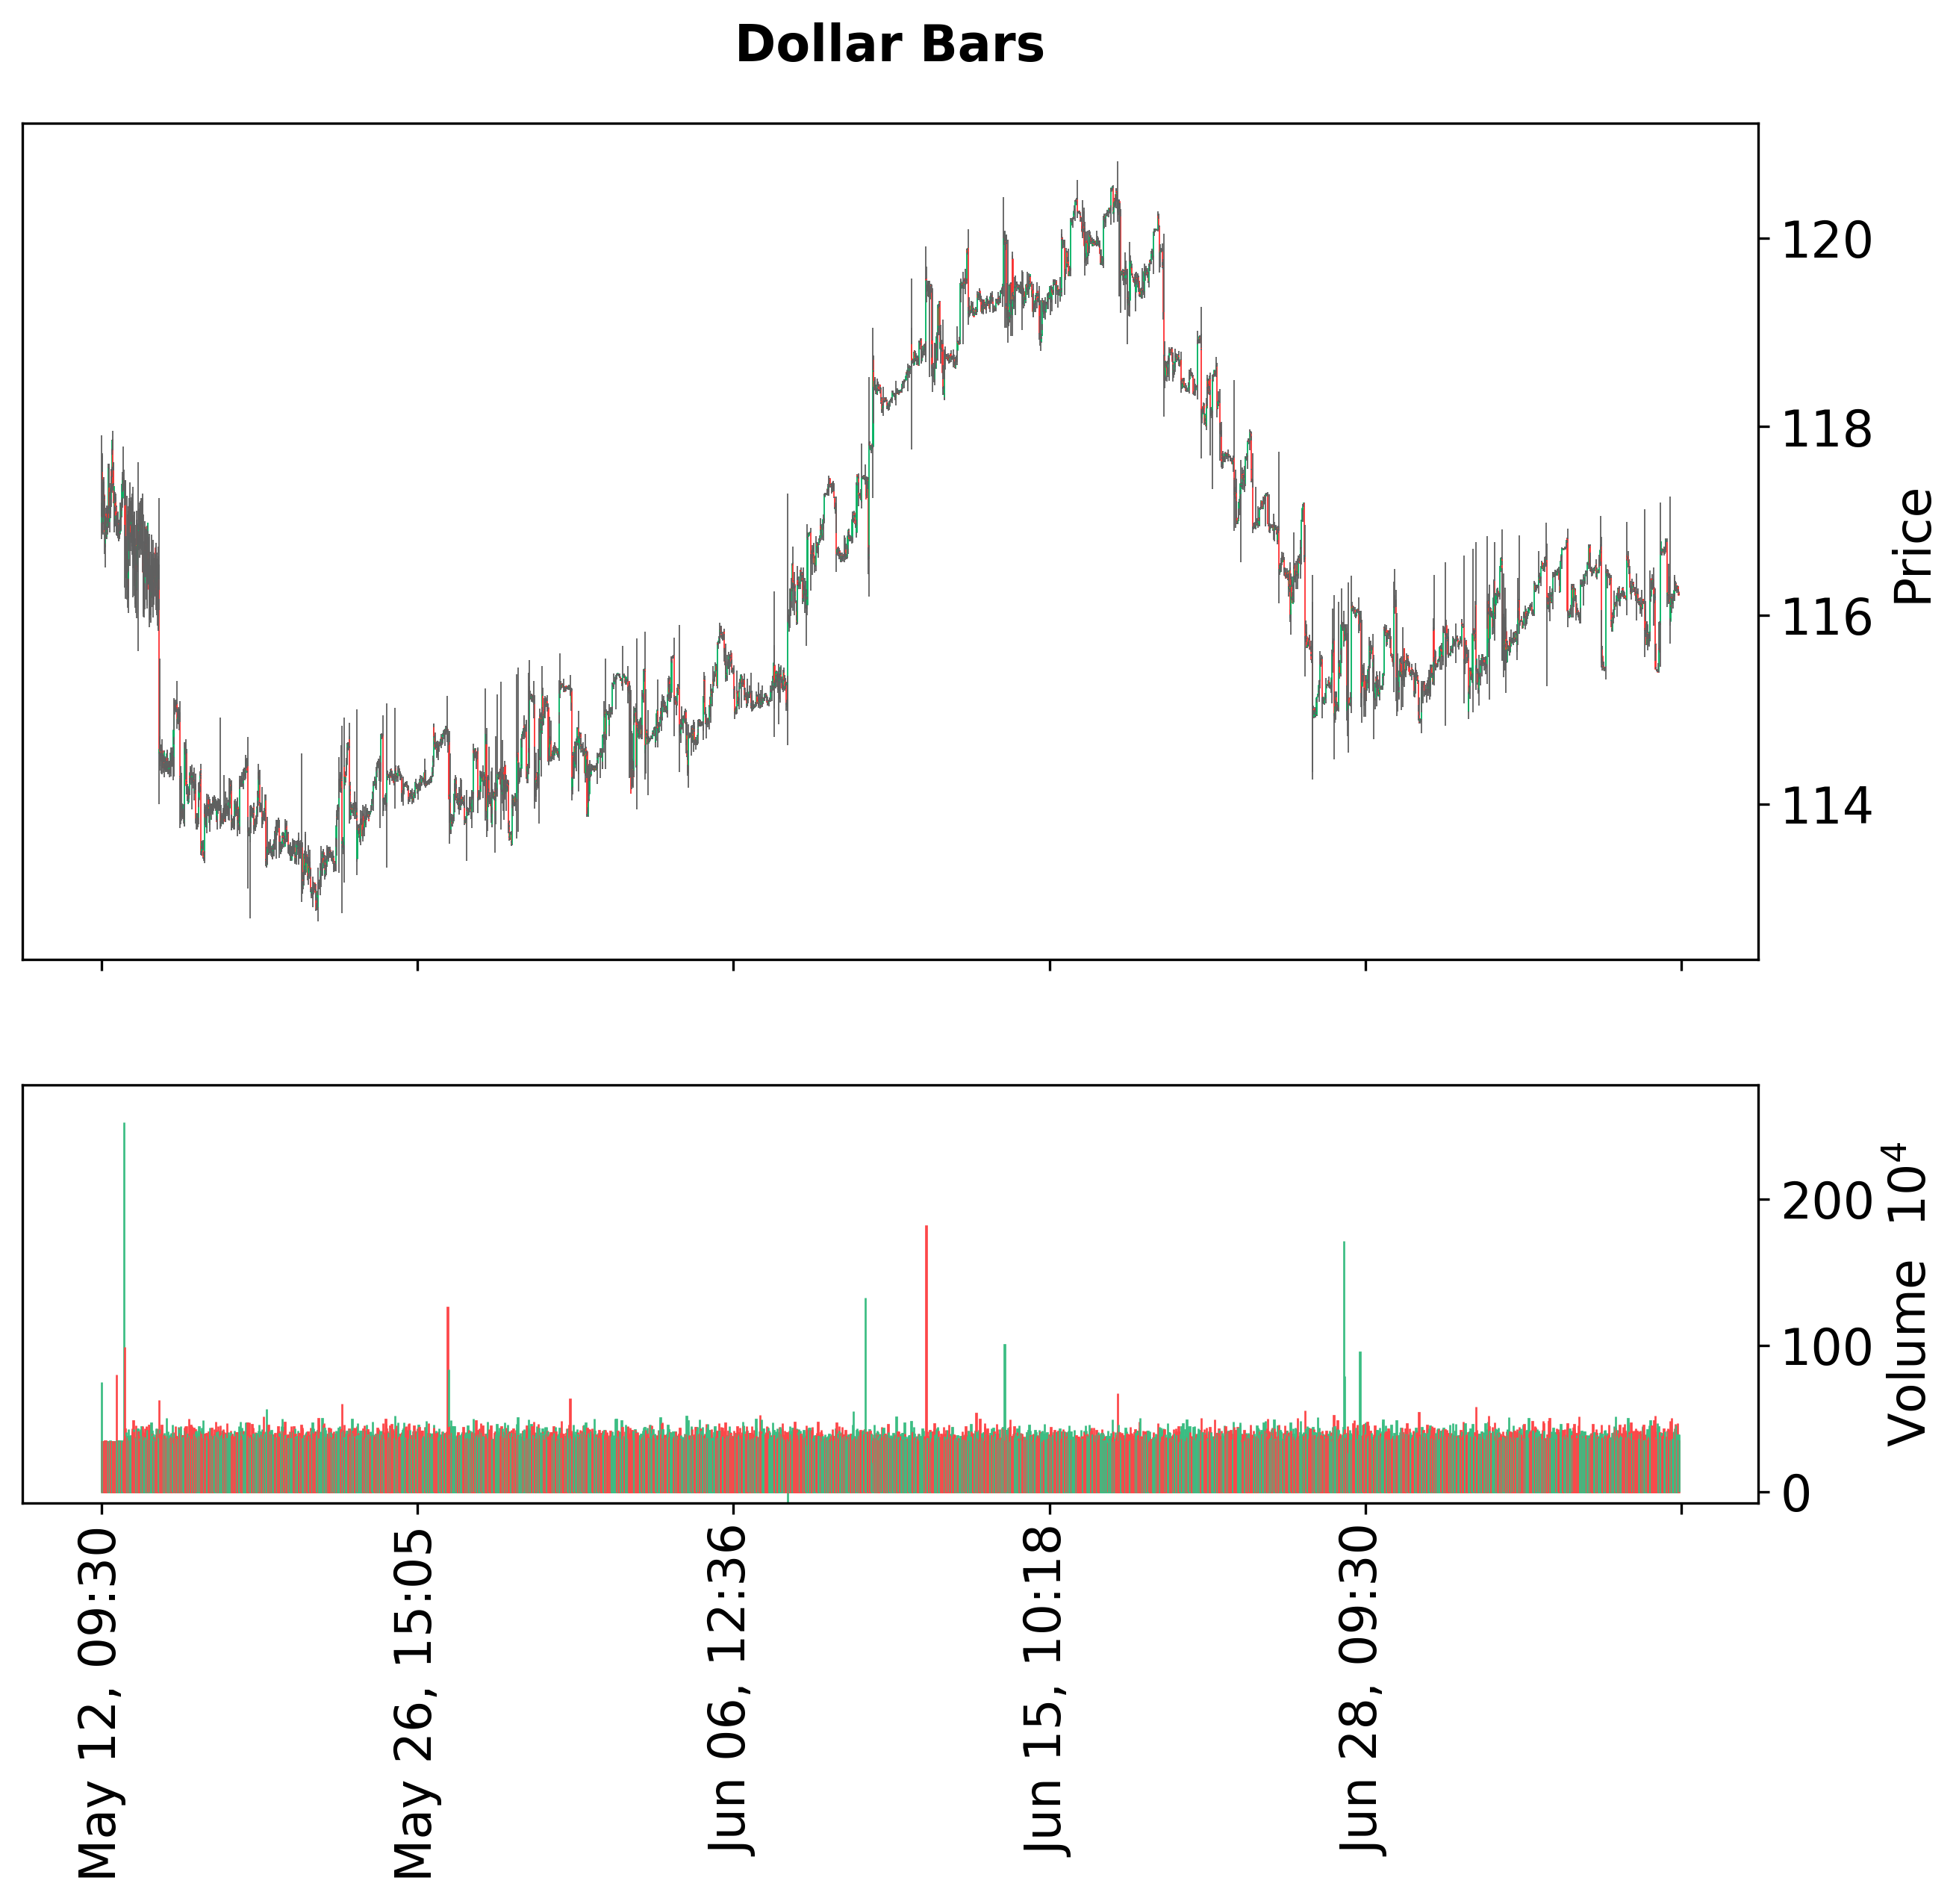

In [71]:
bars = dollar_repeat_bars.copy(deep=True).reset_index(drop=True).set_index('date_time')
bars.index = pd.to_datetime(bars.index.strftime('%Y-%m-%d %H:%M'))

fig, axs = plt.subplots(2, 1, figsize=(10, 8),
                        dpi=300, sharex=True,
                        height_ratios=[2,1])
axs[1].yaxis.set_ticks_position('right')
axs[1].yaxis.set_label_position('right')
# axs[1].xaxis.set_ticks(x_ticks)
axs[0].set_title('Dollar Bars')
mpf.plot(bars, type='candle', style='yahoo',
        ax=axs[0], show_nontrading=False, volume_exponent=4,
        volume=axs[1], xrotation=90, tight_layout=False)
